## 自动编码器
> 自动编码器是可以有效学习输入数据隐藏表示特征的神经网络.我们将其特征成为_coding_._coding_通常比输入数据的维度小很多,所以可以用来对数据进行维度降维处理.
这是一种非监督的学习方式.

输入数据:可以是图片,矩阵数值数据等形式.
约束:在训练自动编码器过程中,我们可以对其_coding_进行限制,比如说,限制其维度;或者我们可以在输入数据中加入噪音,使其重构原数据.这里加噪音的作用主要使其自动编码器更具鲁棒性,更好的挖掘该数据集的隐藏表现特征_coding_

在本文中,我们将探索自动编码器的原理,可以添加何种类型的约束,如何用tensorflow实现.



## 通俗理解
自动编码器将输入数据强制转换成一个有效的隐层表示,然后输入的时候希望和输入越接近越好!
![自动编码器](../resources/images/autoencoder_1.png)
自动编码器分为两部分:
- 编码器:将输入数据转换成_coding_.
- 解码器:将_coding_转换成输出数据.

通常,编码器和解码器都可以使用多层神经网络(MLP)构成.

## 1.实现一个简单的线性自动编码器
使用线性激活函数,损失函数为Mean Squared Error(MSE).

In [5]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

In [6]:
n_inputs = 784 #
n_hidden = 2 # 2D inputs
n_outputs = n_inputs

learning_rate = 0.01

In [7]:
X = tf.placeholder(tf.float32,shape=[None,n_inputs])
hidden = fully_connected(X,n_hidden,activation_fn=None) #None 表示这里使用线性
outputs = fully_connected(hidden,n_outputs,activation_fn=None)

In [8]:
#重构误差--MSE
re_loss = tf.reduce_mean(tf.square(outputs-X))

In [9]:
#优化器
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(re_loss)

In [10]:
#初始化所有变量
init = tf.global_variables_initializer()

In [11]:
# 加载数据集  这里使用minist数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [12]:
n_iterations = 200
coding_dim = n_hidden
batch_size = 256
with tf.Session() as sess:
    sess.run(init)
    total_batch = int(mnist.train.num_examples/batch_size)
    for _ in range(n_iterations):
        for _ in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            training_op.run(feed_dict={X:batch_xs})
#     coding_val = coding.eval(feed_dict:{X:mnist.test.images[:10]})
    

## 堆叠自动编码器(Stacked Autoencoder)
自动编码器可以有多个隐藏层,增加多个隐藏层可以帮助自动编码器学习更加复杂的_coding_.!
![堆叠自动编码器](../resources/images/stackedAE.png)

### Tensorflow 实现
使用一个深层的MLP进行堆叠自动编码器的实现.使用ELU的激活函数.
现在还是以MNIST为例.

In [13]:
n_inputs,n_outputs = 28*28,28*28
n_hidden_1 = 1000
n_hidden_2 = 500
n_hidden_3 = 256

learning_rate = 0.01
l2_reg = 10e-5

n_epochs = 10
batch_size = 200

In [14]:
X = tf.placeholder(tf.float32,shape=(None,n_inputs))
with tf.contrib.framework.arg_scope(
        [fully_connected],
        activation_fn = tf.nn.elu,
    weights_initializer = tf.contrib.layers.variance_scaling_initializer(),
    weights_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)):
    
    hidden1 = fully_connected(X,n_hidden_1)
    hidden2 = fully_connected(hidden1,n_hidden_2)
    hidden3 = fully_connected(hidden2,n_hidden_3)
    outputs = fully_connected(hidden3,n_outputs,activation_fn=None)


In [15]:
# loss function: MSE + reg_loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs-X))  
reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss]+reg_loss) #列表元素相加
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [16]:
from __future__ import print_function
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches),end='')
            X_batch,y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_all_layers.ckpt")

0 Train MSE: 0.0685086
1 Train MSE: 0.0665917
2 Train MSE: 0.0693068
3 Train MSE: 0.0686476
4 Train MSE: 0.0721094
5 Train MSE: 0.0651432
6 Train MSE: 0.0547794
7 Train MSE: 0.0292038
8 Train MSE: 0.0214007
9 Train MSE: 0.0179547


# Evaluate Test Data Set

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


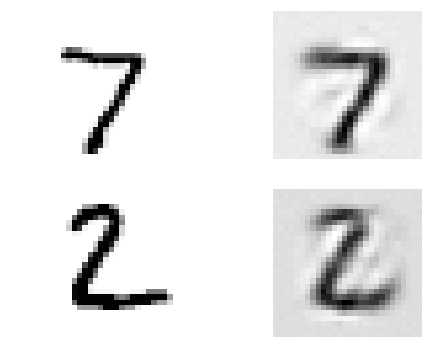

In [17]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")
#----------------------------------------------------------------------------------
    
with tf.Session() as sess:
    saver.restore(sess,"./my_model_all_layers.ckpt")
    X_test = mnist.test.images[:2]
    outputs_val = outputs.eval(feed_dict={X:X_test})

fig = plt.figure(figsize=(8,3*2))
for i in range(2):
    plt.subplot(2,2,i*2+1)
    plot_image(X_test[i])
    plt.subplot(2,2,i*2+2)
    plot_image(outputs_val[i])

### Display the original image and reconstruction

In [18]:
#该函数为上述代码整理所得.
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        
#exmaple :show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

## Stacked denoising Autoencoder

In [19]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings in hidden layers
n_hidden3 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.01
noise_level = 1 # noise ratio

n_epochs = 20
batch_size = 200

In [20]:
X = tf.placeholder(tf.float32,shape=[None,n_inputs])
X_noisy = X + noise_level*tf.random_normal(tf.shape(X)) # add guassian noises

hidden1 = tf.layers.dense(X_noisy,n_hidden1,activation=tf.nn.relu,name='hidden1')
hidden2 = tf.layers.dense(hidden1,n_hidden2,activation=tf.nn.relu,name='hidden2')
hidden3 = tf.layers.dense(hidden2,n_hidden3,activation=tf.nn.relu,name='hidden3')
outputs = tf.layers.dense(hidden3,n_outputs,name='outputs')

In [21]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [22]:
# train process
import sys
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples//batch_size
        for i in range(n_batches):
            print("\r{}%".format(100 * i // n_batches), end="")
            sys.stdout.flush() #缓冲区实时输出.
            X_batch,y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.0453503
1 Train MSE: 0.04184
2 Train MSE: 0.0422351
3 Train MSE: 0.0420889
4 Train MSE: 0.0421068
5 Train MSE: 0.0397888
6 Train MSE: 0.0394123
7 Train MSE: 0.0388018
8 Train MSE: 0.040082
9 Train MSE: 0.0393599
10 Train MSE: 0.0392673
11 Train MSE: 0.0403794
12 Train MSE: 0.0395581
13 Train MSE: 0.0400826
14 Train MSE: 0.0407527
15 Train MSE: 0.0417729
16 Train MSE: 0.0397377
17 Train MSE: 0.0396115
18 Train MSE: 0.0405759
19 Train MSE: 0.0402594


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_gaussian.ckpt


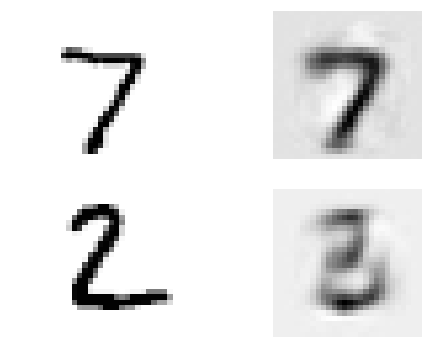

In [23]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_gaussian.ckpt")

### 自动编码器 + Dropout Layer

In [24]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
dropout_rate = 0.3

n_epochs = 5
batch_size = 200

tf.reset_default_graph()

In [25]:
# The implemention of stacked autoencoder with dropout layer
training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)
hidden1 = tf.layers.dense(X_drop,n_hidden1,activation=tf.nn.relu,name='hidden1')
hidden2 = tf.layers.dense(hidden1,n_hidden2,activation=tf.nn.relu,name='hidden2')
hidden3 = tf.layers.dense(hidden2,n_hidden3,activation=tf.nn.relu,name='hidden3')
outputs = tf.layers.dense(hidden3,n_outputs,name='outputs')

In [26]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs-X))
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [27]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples//batch_size
        for i in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch,y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch,training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt") 

0 Train MSE: 0.0281838
1 Train MSE: 0.0258091
2 Train MSE: 0.0243486
3 Train MSE: 0.0238641
4 Train MSE: 0.0243637


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_dropout.ckpt


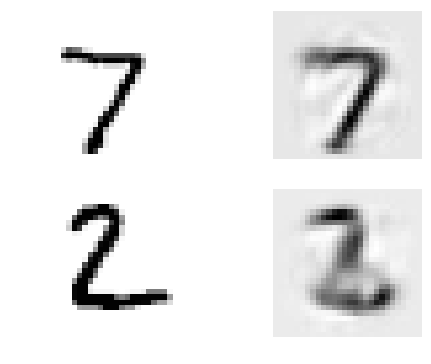

In [28]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

## Sparse Autoencoder 稀疏自动编码器

In [29]:
#重置图
tf.reset_default_graph()

In [30]:
n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs
n_epochs = 100
batch_size = 1000
learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2 #调节稀疏程度的系数(权重)

In [31]:
# KL 离散度
def kl_divergence(p,q):
    return p*tf.log(p/q)+(1-p)*tf.log((1-p)/(1-q))

In [32]:
X = tf.placeholder(tf.float32,shape=[None,n_inputs])

hidden1 = tf.layers.dense(X,n_hidden1,activation=tf.nn.sigmoid)
outputs = tf.layers.dense(hidden1,n_outputs)

hidden1_mean = tf.reduce_mean(hidden1,axis=0)
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target,hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs-X))
loss = reconstruction_loss + sparsity_weight * sparsity_loss